## Data Preprocessing 
The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.
Lets first import the required packages.

In [27]:
%%capture
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.base import TransformerMixin ,BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential ,model_from_json
from tensorflow.keras.layers import Embedding,Dense,Dropout ,GlobalMaxPool1D

from IPython.display import clear_output
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

## Data Loading
The data are stored in 11 csv formated files.We first load this data and then save it into a single combined file for further analysis.The name of the file is the same as the name of the crisis.The Tweets in each files has been labeled  as "on-topic" or "off-topic".
First lets load the data and understand it.

We will be using the Pipeline from Sklean library to streamline the preprocessing routine. As a result the the classes in the analysis should be compatible with the pipeline arcitecture.

In [28]:
COMBINDED_DATASET='combined.csv'
DATA_DIRECTORY='./datasets'
class DatasetExtractor(BaseEstimator,TransformerMixin):
  #Extractor class that loads multiple Tweet files and creates a single unified file
    
    def transform(self,X,y=None):
        return self.hot_load()
    
    def hot_load(self):
    #Loads the pre-combined file if exists otherwise load all the files
        combined_file_path=f'{DATA_DIRECTORY}/{COMBINDED_DATASET}'
        if os.path.isfile(combined_file_path):
            print('File Exists.Reloaded.')
            return pd.read_csv(combined_file_path, index_col=0)
        print('Loading Files..')
        combined_dataset=self.load_data()
        combined_dataset.to_csv(combined_file_path)
        return combined_dataset
    
    def load_data(self):
    #Loads multiple disaster related tweet file and returns a Single Pandas data frame  
        combined_dataset=pd.DataFrame()
        for file_name in os.listdir(path=DATA_DIRECTORY):
            category=self.extract_category_name(file_name)
            df=pd.read_csv(f'{DATA_DIRECTORY}/{file_name}')
            df['category']= category    
            combined_dataset=combined_dataset.append(df,ignore_index = True)
        return  combined_dataset  
    
    def extract_category_name(self,file_name):
    #Helper method that extracts the Disaster Category from the file name
        category=file_name.split('.')[0]
        if '_' in category:
            category=category.split('_')[0]
        return category 

In [29]:
dataset=DatasetExtractor().transform(None)
dataset.head()

File Exists.Reloaded.


,tweet id,tweet,label,category
0,'348351442404376578',@Jay1972Jay Nope. Mid 80's. It's off Metallica...,off-topic,floods
1,'348167215536803841',Nothing like a :16 second downpour to give us ...,off-topic,floods
2,'348644655786778624',@NelsonTagoona so glad that you missed the flo...,on-topic,floods
3,'350519668815036416',"Party hard , suns down , still warm , lovin li...",off-topic,floods
4,'351446519733432320',@Exclusionzone if you compare yourself to wate...,off-topic,floods


 
## Data Cleaning

### Text cleaning
Here we will use the regular expressions and replace functionality in Pandas to remove the unwanted noise in the data.

### Re-Tweets:
They add no real value to the data and can sometimes lead to overfitting 

### URL's
They do not deliver any predictive power.In the worst case scenario they might lead to overfitting.

### Symbols
Hashtags, commas, points and and all kind of punctuation symbols are removed.

### White Spaces
We also get ride of any additional white spaces in the texts that might be created due to the previous steps.

### Lower case
All texts are transformed to lowercase.

### Location Names
The names of the location which disaster happened were repeated in so many tweets.We want to prevent the model from  associating these location names with the crisis and as a result we remove the most frequent ones from the Tweets.

 

In [30]:
STOP_WORDS=["Boston", "Oklahoma","Texas","Nepal","California","Calgary","Chile","Alberta","Pakistan" ,"WestTX","Canada","yycflood","USA","'S",]
class DatasetCleaner(BaseEstimator,TransformerMixin):
    """Removes Redundent features and rows with missing values"""
    def transform(self,X,y=None):
        columns=X.columns.tolist()
        X.columns=[column.strip() for column in columns]
        X=X.drop('tweet id',axis=1)
        X=X.dropna()
        X['tweet']=X['tweet'].str.replace('@', '')
        X['tweet']=X['tweet'].str.replace('#', '')
        X['tweet']=X['tweet'].str.replace('.', '')
        X['tweet']=X['tweet'].str.replace(',', '')
        X['tweet']=X['tweet'].str.replace('http\S+', '',regex=True)
        X['tweet']=X['tweet'].str.replace('@\w+', '',regex=True)
        X['tweet']=X['tweet'].str.replace('\s+', '',regex=True)
        X['tweet']=X['tweet'].str.strip()
        X['tweet']=X['tweet'].str.lower()
        for word in STOP_WORDS:
            word=word.lower()
            X['tweet']=X['tweet'].str.replace(word, '') 
        return X

In [31]:
dataset_cleaned=DatasetCleaner().transform(dataset)
dataset_cleaned.head()

,tweet,label,category
0,jay1972jaynopemid80itoffmetallica2ndalbumridet...,off-topic,floods
1,nothinglikea:16seconddownpourtogiveussomemuchn...,off-topic,floods
2,nelsontagoonasogladthatyoumissedthefloodsandsa...,on-topic,floods
3,partyhardsunsdownstillwarmlovinlifesmileharddo...,off-topic,floods
4,exclusionzoneifyoucompareyourselftowaterdoesth...,off-topic,floods


 ##  Re-Sampling

Here we see how many tweets we have in each category.This would be total number of tweets.Each file has **on-topic** and **off-topic** tweets which is the way they have been labeled by human labelers.

In [32]:
Crisis=pd.DataFrame(dataset['category'].value_counts())
Crisis.reset_index(inplace=True)
Crisis.rename(columns={'index':'Crisis',"category":'Tweet Count'} ,inplace=True)
Crisis

,Crisis,Tweet Count
0,floods,20064
1,bombing,10012
2,hurricane,10008
3,explosion,10006
4,tornado,9992
5,earthquake,9057


Text(0.5, 0, ' ')

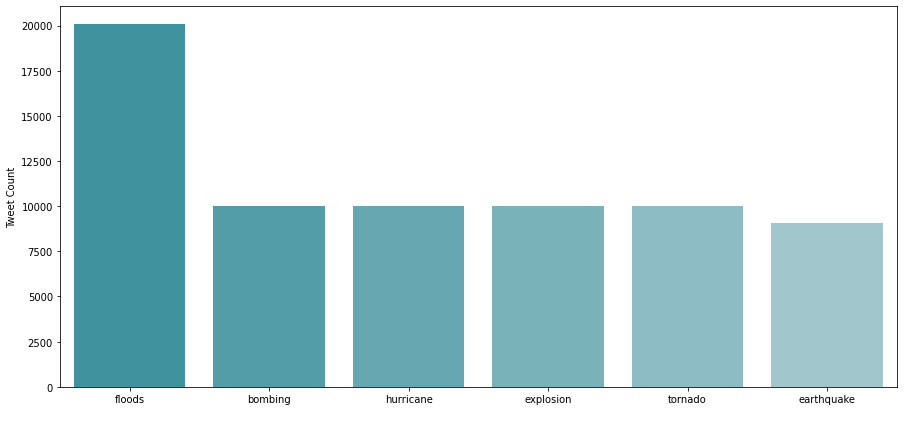

In [33]:
f,ax =plt.subplots(figsize=(15,7))
sns.barplot(x='Crisis',y='Tweet Count',data=Crisis ,palette=sns.light_palette((210, 90, 60),10, input="husl" ,reverse=True),ax=ax)
ax.set_xlabel(' ')

### All Tweets ( On-Topic and off-Topic ) for each category 

Here lets see how many related (on-topic) Tweets we have in each category.

In [34]:
dataset['label_full']=dataset['label']+'_'+dataset['category']
Crisis_topics=pd.DataFrame(dataset['label_full'].value_counts())
Crisis_topics.drop('On-topic_earthquake',axis=0,inplace=True)
Crisis_topics.reset_index(inplace=True)
Crisis_topics.rename(columns={'index':'Crisis',"label_full":'Tweet Count'} ,inplace=True)

Crisis_topics

,Crisis,Tweet Count
0,on-topic_floods,10603
1,off-topic_floods,9461
2,on-topic_hurricane,6138
3,on-topic_bombing,5648
4,on-topic_explosion,5246
5,off-topic_tornado,5165
6,on-topic_tornado,4827
7,off-topic_explosion,4760
8,on-topic_earthquake,4580
9,Off-topic_earthquake,4475


Text(0.5, 1.0, 'Numer of on-topic and off-topic Tweets in each crisis Category ')

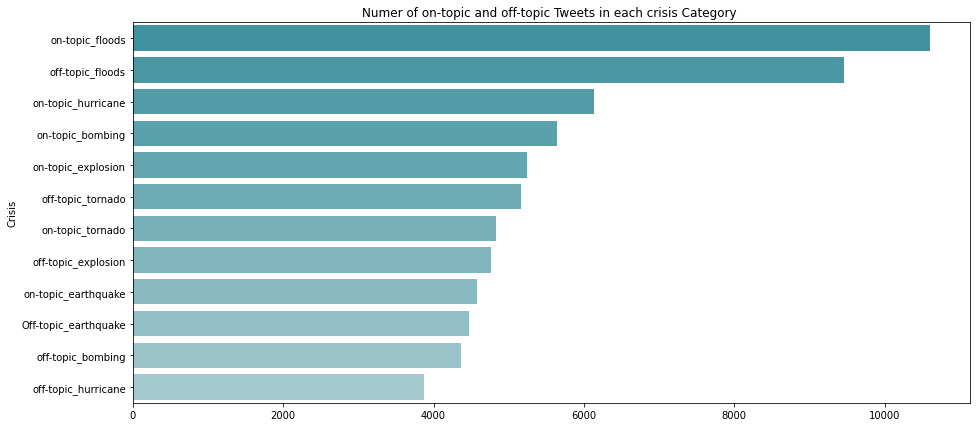

In [35]:
f,ax =plt.subplots(figsize=(15,7))
sns.barplot(y='Crisis',x='Tweet Count',data=Crisis_topics ,palette=sns.light_palette((210, 90, 60),20, input="husl" ,reverse=True),ax=ax)
ax.set_xlabel(' ')
ax.set_title('Numer of on-topic and off-topic Tweets in each crisis Category ')

### On-Topic Tweets

Lets take a look at only the on topic Tweets in each Category:
We can see that labels are balanced. We have about 5000 on-topic Tweets in each category except flood.

In [36]:
Crisis_topics_on_topic= Crisis_topics[Crisis_topics['Crisis'].str.contains("on-topic")]
Crisis_topics_on_topic['Tweet_pct']=Crisis_topics_on_topic['Tweet Count']*100/Crisis_topics_on_topic['Tweet Count'].sum()
Crisis_topics_on_topic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Crisis,Tweet Count,Tweet_pct
0,on-topic_floods,10603,28.624264
2,on-topic_hurricane,6138,16.570380
3,on-topic_bombing,5648,15.247557
4,on-topic_explosion,5246,14.162302
6,on-topic_tornado,4827,13.031154
8,on-topic_earthquake,4580,12.364343


Text(0, 0.5, 'Percentage of on-topic Tweets in Each Category')

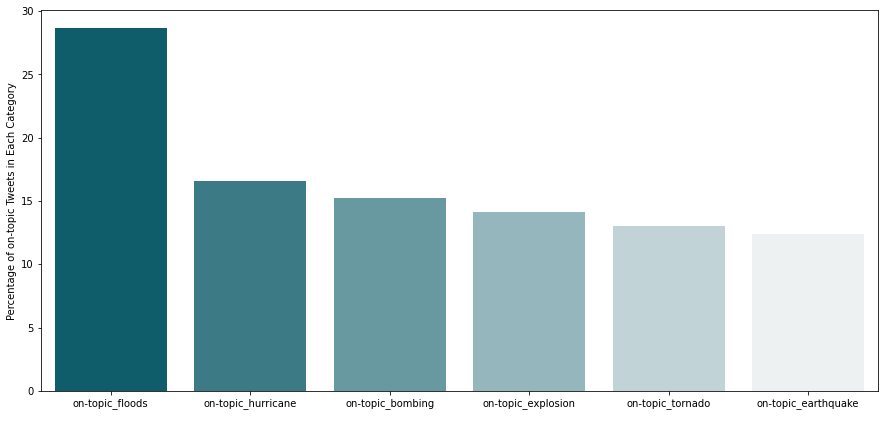

In [37]:
f,ax =plt.subplots(figsize=(15,7))
sns.barplot(x='Crisis',y='Tweet_pct',data=Crisis_topics_on_topic ,palette=sns.light_palette((216, 100, 40), input="husl" ,reverse=True),ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Percentage of on-topic Tweets in Each Category')

###  Off-Topic Tweets
For avoiding overfitting here we use a random set of off-topic tweets from each of the categories.We label all these tweets as **unrelated**. Using these additional label  would let the model learn to better distinguish between the related and unrelated tweets for each category.



In [38]:
Crisis_topics_off_topic= Crisis_topics[~Crisis_topics['Crisis'].str.contains("on-topic")]
total_off_topic_tweets=Crisis_topics_off_topic['Tweet Count'].sum()
print("Total Number of 'Off-Topic' Tweets",total_off_topic_tweets)
Crisis_topics_off_topic.head()

Total Number of 'Off-Topic' Tweets 32095


,Crisis,Tweet Count
1,off-topic_floods,9461
5,off-topic_tornado,5165
7,off-topic_explosion,4760
9,Off-topic_earthquake,4475
10,off-topic_bombing,4364


#### Imbalanced Data

Lets plot the total number of off-topic tweets along with the on-topic tweets.Note that the "off-topic" would also be one of our prediction categories, as a result, this category should also have the same number of tweets as the other categories. 


In [39]:
Crisis_topics_off_topic['Crisis']='unrelated'
Crisis_topics_off_topic_g=Crisis_topics_off_topic.groupby(by='Crisis').sum()
Crisis_topics_off_topic_g.reset_index(inplace=True)
all_topics =Crisis_topics_off_topic_g.append(Crisis_topics_on_topic[['Crisis','Tweet Count']])
all_topics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Crisis,Tweet Count
0,unrelated,32095
0,on-topic_floods,10603
2,on-topic_hurricane,6138
3,on-topic_bombing,5648
4,on-topic_explosion,5246
6,on-topic_tornado,4827
8,on-topic_earthquake,4580


Text(0.5, 1.0, 'Imbalanced Dataset: Total Number of Tweets in each category')

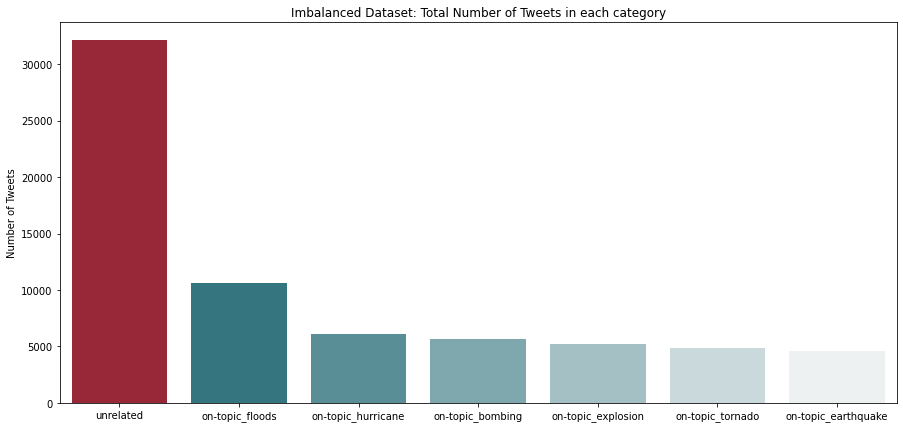

In [40]:
f,ax =plt.subplots(figsize=(15,7))
blues=sns.light_palette((216, 100, 40),all_topics.shape[0], input="husl" ,reverse=True)
blues[0]=sns.color_palette("RdBu", 10)[0]
sns.barplot(x='Crisis',y='Tweet Count',data=all_topics ,palette=blues, ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Number of Tweets')
ax.set_title( 'Imbalanced Dataset: Total Number of Tweets in each category')

#### Balancing the Data
As we can see the number of *unrelated* tweets are way higher than the actual on topic tweets.To solve the problem, we resample a subset of these these unrelated Tweets.The total number that we re-sample from these unrelated tweets would be equal to the average number of all tweets in each dataset.

In [41]:
class DistributionValidSampler(BaseEstimator,TransformerMixin):
    """Samples the (related and random ) tweets with equal proportion"""
    def __init__(self,unrelated_size=None ,ignore_unrelated_proportion=True):
        self._unrelated_size=unrelated_size
        self._ignore_unrelated_proportion=ignore_unrelated_proportion

        
    def transform(self,X,y=None):
        #Shuffle tweets
        X_=X.sample(frac=1).reset_index(drop=True)
        X_=self._label_categories(X_)  
        related,unrelated =self._equal_split(X_)
        X_=self._merge(related,unrelated)
        X_=X_.drop('category',axis=1)       
        return X_
    
    def _label_categories(self,X):
        """Assings the category name to on-topic tweets and unrelated to off-topic tweets in 
         each category
        """   
        if self._ignore_unrelated_proportion:
            X['label']=X.apply(lambda row: row['category'] if 'on-topic' in row['label'] else 'unrelated',axis=1 ) 
        else:
            X['label']=X.apply(lambda row: row['category'] if 'on-topic' in row['label'] else 'unrelated_'+row['category'],axis=1 )  
        return X
    
    def _equal_split(self,X):
        """Splits the dataseta into related and unrelated tweets.
          This ensures that the number of unrelated tweets are not too high and 
          is in reasonable range.
        """
        related=X[X['label'].str.contains('unrelated')==False]
        unrelated=X[X['label'].str.contains('unrelated')]
        ave_tweets=self._average_tweet_per_category(X)
        unrelated=self._slice(unrelated,size=self._unrelated_size ,ave_size=ave_tweets)
        return related,unrelated
    
    def _merge(self,X1,X2):
        """Merges the dataframes toghether"""
        X=pd.DataFrame()
        X=X.append(X1)
        X=X.append(X2)
        return X
    
    def _slice(self,X, size ,ave_size):
        """Extracts a subset of rows from a dataframe"""
        if size is None:
            size =ave_size
        if size < X.shape[0]:
            return X[:size]
        return X    
    
    def _average_tweet_per_category(self,X):
        """Calculate the average number of tweets across all tweet categories"""
        category_values=pd.DataFrame(X['label'].value_counts())
        category_values=category_values.drop('unrelated',axis=0)
        return int(category_values['label'].mean())
        

In [42]:
dataset_resampled=DistributionValidSampler().transform(dataset_cleaned)
dataset_resampled_topics=pd.DataFrame(dataset_resampled['label'].value_counts())
display(dataset_resampled_topics)
dataset_resampled_topics.reset_index(inplace=True)

,label
floods,10603
unrelated,6173
hurricane,6138
bombing,5648
explosion,5246
tornado,4827
earthquake,4580


Lets see the number of tweets in each category in the re-sampled dataset:

Text(0.5, 1.0, 'Balanced Dataset: Total Number of Tweets in each category')

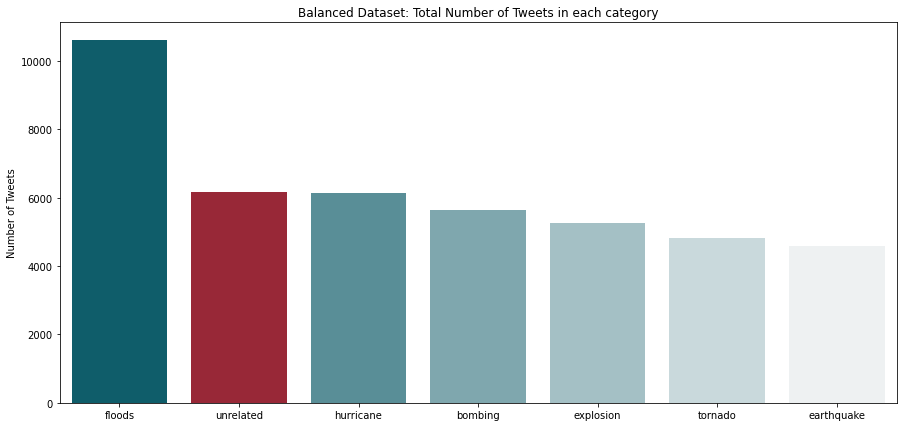

In [43]:
f,ax =plt.subplots(figsize=(15,7))
blues=sns.light_palette((216, 100, 40),dataset_resampled_topics.shape[0], input="husl" ,reverse=True)
blues[1]=sns.color_palette("RdBu", 10)[0]
sns.barplot(x='index',y='label',data=dataset_resampled_topics ,palette=blues, ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Number of Tweets')
ax.set_title( 'Balanced Dataset: Total Number of Tweets in each category')

# Data Transformation
###  Tokenization
We have used the Tokenizer() class from the Keras Preprocessing  to vectorize our text data. It will turn our sentences into sequences of integers.
### Padding
We pad all the vectorized text sequences with zeros to make all the sequences of the same length. 

In [44]:
class TextTokenizer(BaseEstimator,TransformerMixin):
    """This is a simple Wrapper class for Keras Tokenizer."""
    def __init__(self,pad_sequences,num_words=10000,max_length=100,max_pad_length=100 ):
        self._num_words=num_words
        self.max_length=max_length
        self._tokenizer=None
        self._pad_sequences=pad_sequences
        self._max_pad_length=max_pad_length
        self.vocab_size=None
        self.tokenizer=None
        
    def transform(self,X,y=None):
        self.tokenizer,self.vocab_size=self._get_tokenizer(X['tweet'])
        X['tweet_encoded']=self.tokenizer.texts_to_sequences(X['tweet'])
        X['tweet_encoded']= X['tweet_encoded'].apply(lambda x: self._pad_sequences([x],maxlen=self._max_pad_length ,padding='post')[0])
        
        return X
    def _get_tokenizer(self,X):
        tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=self._num_words)
        tokenizer.fit_on_texts(X)
        vocab_size=len(tokenizer.word_index)+1
        return tokenizer,vocab_size

In [45]:
tokenization=TextTokenizer(pad_sequences)
dataset_tokenized=tokenization.transform(dataset_resampled)
vocab_size=tokenization.vocab_size
print('Vocab Size:',vocab_size)
dataset_tokenized.head()

Vocab Size: 65279


,tweet,label,tweet_encoded
1,rtabc7:photo:usgsshakemapshowslocationof82-mag...,earthquake,"[1739, 44, 7530, 7531, 1, 0, 0, 0, 0, 0, 0, 0,..."
2,glassjewrtyouranonnews:wolfblitzertotornadosur...,tornado,"[7532, 1740, 1741, 1121, 0, 0, 0, 0, 0, 0, 0, ..."
5,aircrafttoevacuatecanadianssettoarriveinearthq...,earthquake,"[7533, 505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,justgotoffthephonewithmysisterinjerseyshesaide...,hurricane,"[7534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,rtlovefor:riptothe8year-oldgirlwhodiedinexplos...,bombing,"[506, 42, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Label Encoding
In this step all the target labels are converted to integer values.We use the LabelEncoder class from the Sklean package.

### One Hot Encoding 
In the next step we use the integer values for labels and create a one hot vector to be used for the machine learning analysis.

In [46]:
class LabelOneHotEncoder(BaseEstimator,TransformerMixin):
    """Transfroms the Categorical data to One Hot vector"""
    def __init__(self):
        self.label_encoder=None
        self.one_hot_encoder=None
        
    def transform(self,X,y=None):
        self.label_encoder=LabelEncoder().fit(X['label'])
        self.one_hot_encoder=to_categorical
        num_classes=len(set(X['label']))
        X['label_encoded']= self.label_encoder.transform(X['label'].values)
        X['label_one_hot']= X['label_encoded'].apply(lambda x: self.one_hot_encoder([x],num_classes=num_classes)[0])   
        
        return X

In [47]:
encoder=LabelOneHotEncoder()
dataset_encoded=encoder.transform(dataset_resampled)
dataset_encoded.head()

,tweet,label,tweet_encoded,label_encoded,label_one_hot
1,rtabc7:photo:usgsshakemapshowslocationof82-mag...,earthquake,"[1739, 44, 7530, 7531, 1, 0, 0, 0, 0, 0, 0, 0,...",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,glassjewrtyouranonnews:wolfblitzertotornadosur...,tornado,"[7532, 1740, 1741, 1121, 0, 0, 0, 0, 0, 0, 0, ...",5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
5,aircrafttoevacuatecanadianssettoarriveinearthq...,earthquake,"[7533, 505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,justgotoffthephonewithmysisterinjerseyshesaide...,hurricane,"[7534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
8,rtlovefor:riptothe8year-oldgirlwhodiedinexplos...,bombing,"[506, 42, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### Word embeddings
Word embeddings can be generated using pre-trained word embeddings such as Glove and Word2Vec. Here we use the Embedding Layer of Keras maps the pre-calculated integers to a dense vector of the embedding.



### Train test Data set 
In this section we split our data into training and testing datasets. Here we use the train_test_split tool from the sklean library to achieve this goal.



In [48]:
X_train,X_test,y_train,y_test =train_test_split(dataset_encoded['tweet_encoded'],dataset_encoded['label_one_hot'],test_size=0.3,stratify=dataset_encoded['label_encoded'])
X_train=np.array(X_train.values.tolist())
X_test=np.array(X_test.values.tolist())
y_train=np.array(y_train.values.tolist())
y_test=np.array(y_test.values.tolist())
print('Number of Tweets in Training set: ',X_train.shape[0])
print('Number of Tweets in Test set: ',X_test.shape[0])

Number of Tweets in Training set:  30250
Number of Tweets in Test set:  12965


# Modeling 

### Model Architecture
For the modeling we will use the Keras's Sequential model API.


In [49]:
max_length=100
embeding_dim=50
num_classes=y_train[0].shape[0]
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           3263950   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
Total params: 3,264,537
Trainable params: 3,264,537
Non-trainable params: 0
______________________________________________

In [50]:
class PlotLosses(tf.keras.callbacks.Callback):
    """Simple utility function to plot the model losses during training"""
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
plot_losses = PlotLosses() 

def save_model(model,save_name):
    with open(save_name,'w+') as f:
        f.write(model.to_json())
    model.save_weights(save_name+'.h5') 

###  Training 

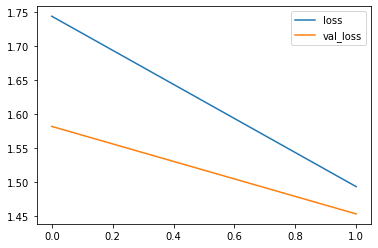

In [51]:
model.fit(X_train,y_train,epochs=2,batch_size=10,verbose=0,validation_data=(X_test,y_test),callbacks=[plot_losses])
save_model(model,'model')

### Evaluation

In [52]:
# load json and create model
json_file = open('model', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 44.79%


###  Hyper-parameter Optimization

In [53]:
def create_model(dropout, dense_size, vocab_size, embedding_dim, maxlen):
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout))
    model.add(Dense(dense_size,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [54]:
# Main settings
epochs = 5
embedding_dim = 50
maxlen = 100
vocab_size=10000
output_file = 'output.txt'
dense_size=[10, 50,100],
# Parameter grid for grid search
param_grid = dict(dropout=[0.1],
                  dense_size=[10, 50,100],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5 ,n_jobs=2)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
# Save and evaluate results
with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)  
print('Done')

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 13.8min finished


Best Accuracy : 0.4564
{'vocab_size': 10000, 'maxlen': 100, 'embedding_dim': 50, 'dropout': 0.1, 'dense_size': 50}
Test Accuracy : 0.4662


Done
